In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from imutils import face_utils, translate, resize
from imutils.video import VideoStream, FPS, FileVideoStream
import time

from scipy.spatial import distance as dist
import math

In [2]:
def get_lip_height(lip):
    sum = 0
    for i in [2,3,4]:
        distance = math.sqrt( (lip[i][0] - lip[12-i][0])**2 +
                              (lip[i][1] - lip[12-i][1])**2   )
        sum += distance
    return sum / 3

In [3]:
def get_mouth_height(top_lip, bottom_lip):
    sum = 0
    for i in [8,9,10]:
        # distance between two near points up and down
        distance = math.sqrt( (top_lip[i][0] - bottom_lip[18-i][0])**2 + 
                              (top_lip[i][1] - bottom_lip[18-i][1])**2   )
        sum += distance
    return sum / 3

In [4]:
def check_mouth_open(top_lip, bottom_lip):
    top_lip_height = get_lip_height(top_lip)
    bottom_lip_height = get_lip_height(bottom_lip)
    mouth_height = get_mouth_height(top_lip, bottom_lip)

    # if mouth is open more than lip height * ratio, return true.
    ratio = 0.7
    if mouth_height > min(top_lip_height, bottom_lip_height) * ratio:
        return True
    else:
        return False

In [5]:
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

In [6]:
# for eyes
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 3
COUNTER = 0
TOTAL = 0

In [7]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [8]:
# start and end points' numbers
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(imStart, imEnd) = face_utils.FACIAL_LANDMARKS_IDXS["inner_mouth"]
(leStart, leEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(reStart, reEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

In [9]:
image_dir = "images"
video_dir = "videos"
mask_dir = "masks"
result_dir = "results"

IMG_NAME = "face.jpg"
VIDEO_NAME = "Mironova_3rd_pitch.mp4"
MASK_NAME = 'face_mask.jpeg'

In [10]:
target = "i"

# if video file
if target == "f":
    vs = FileVideoStream(f"{video_dir}/{VIDEO_NAME}").start()
    fileStream = True

# if video stream
elif target == "v":
    vs = VideoStream(src=0).start()
    fileStream = False
    
# if file
elif target == "i":
    img = cv2.imread(f"{image_dir}/{IMG_NAME}")

# this params should be tuned, because now it does not work
out = cv2.VideoWriter(f"{result_dir}/output.mp4", cv2.VideoWriter_fourcc(*'MP4V'), 30.0, (253, 450), True)

In [11]:
face_mask = cv2.imread(f"{mask_dir}/{MASK_NAME}")
h_mask, w_mask = face_mask.shape[:2]

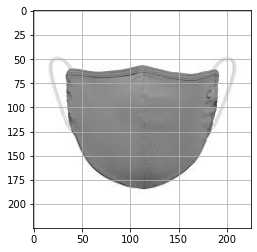

In [12]:
plt.imshow(face_mask)
plt.grid(True);

In [13]:
src_points = {'mask1.jpg': np.float32([[400, 480], [800, 480], [600, 600]]),
              'mask2.jpg': np.float32([[270, 400], [680, 400], [470, 550]]),
              'cat_nose.png': np.float32([[500, 400], [450, 500], [550, 500]]),
              '2_new_year_hat.PNG': np.float32([[250, 750], [400, 850], [550, 750]]),
              'hat.png': np.float32([[150, 620], [250, 644], [350, 620]]),
              'moustache.png': np.float32([[200, 215], [290, 0], [400, 215]]),
              '1_cat_left_ear.PNG': np.float32([[450, 900], [600, 780], [800, 650]]),
              'face_mask.jpeg': np.float32([[120, 185], [35, 55], [185, 55]])}

dst_points_names = {'mask1.jpg': 'eyes',
                    'mask2.jpg': 'eyes',
                    'cat_nose.png': 'nose',
                    '2_new_year_hat.PNG': 'brows',
                    'hat.png': 'brows',
                    'moustache.png': 'moustache',
                    '1_cat_left_ear.PNG': 'left_ear',
                    'face_mask.jpeg': 'lips'}

transparent = {'mask1.jpg': False,
               'mask2.jpg': False,
               'cat_nose.png': True,
               '2_new_year_hat.PNG': True,
               'hat.png': False,
               'moustache.png': False,
               '1_cat_left_ear.PNG': True,
               'face_mask.jpeg': False}

In [14]:
# loop over frames from the video stream
if target == "f" or target == "v":

    while True:
        if target == "f" and not vs.more():
            break

        frame = vs.read()
        if frame is None:
            break
        frame = resize(frame, width=450)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # extract start and end points
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            rightEye = shape[rStart:rEnd]
            mouth = shape[mStart:mEnd]
            imouth = shape[imStart:imEnd]
            lbrow = shape[leStart:leEnd]
            nose = shape[nStart:nEnd]
            jaw = shape[jStart:jEnd]
            ulip = np.append(shape[48:55], shape[60:65][::-1], axis=0)
            blip = np.append(shape[54:60], [shape[48]], axis=0)
            blip = np.append(blip, [shape[60]], axis=0)
            blip = np.append(blip, shape[64:68][::-1], axis=0)

            # calc eyes ratio
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            ear = (leftEAR + rightEAR) / 2.0

            if ear < EYE_AR_THRESH:
                COUNTER += 1
            else:
                if COUNTER >= EYE_AR_CONSEC_FRAMES:
                    TOTAL += 1
                COUNTER = 0

            # draw eyes
    #         leftEyeHull = cv2.convexHull(leftEye)
    #         rightEyeHull = cv2.convexHull(rightEye)
    #         cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
    #         cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

            # print info about eyes
            cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # if mouth is open, [draw mouth]
            if check_mouth_open(ulip, blip):
                imouthHull = cv2.convexHull(imouth)
                cv2.drawContours(frame, [imouthHull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [imouthHull], -1, (0, 255, 0), 1)

                mouthHull = cv2.convexHull(mouth)
                cv2.drawContours(frame, [mouthHull], -1, (0, 255, 255), 1)
                cv2.drawContours(frame, [mouthHull], -1, (0, 255, 255), 1)

            # make eyes mask {
            face_mask_small = face_mask

            if not transparent[MASK_NAME]:
                gray_mask = cv2.cvtColor(face_mask_small, cv2.COLOR_BGR2GRAY)
                ret, mask = cv2.threshold(gray_mask, 230, 255, cv2.THRESH_BINARY_INV)
                face_mask2 = cv2.bitwise_and(face_mask_small, face_mask_small, mask=mask)
            else:
                gray_mask = cv2.cvtColor(face_mask_small, cv2.COLOR_BGR2GRAY)
                ret, mask = cv2.threshold(gray_mask, 30, 255, cv2.THRESH_BINARY)
                face_mask2 = cv2.bitwise_and(face_mask_small, face_mask_small, mask=mask)

            rows, cols = frame.shape[:2]

            dst_points = {'eyes': np.float32([shape[36], shape[45], shape[30]]),
                          'nose': np.float32([shape[30], shape[50], shape[52]]),
                          'brows': np.float32([shape[19], shape[27], shape[24]]),
                          'brows2': np.float32([shape[19], shape[27] -([0, shape[9][1] - shape[27][1]]), shape[24]]),
                          'moustache': np.float32([shape[49], shape[33], shape[53]]),
                          'left_ear': np.float32([shape[2], shape[1], shape[0]]),
                          'lips': np.float32([shape[8], shape[0], shape[16]])}
            M = cv2.getAffineTransform(src_points[MASK_NAME], dst_points[dst_points_names[MASK_NAME]])
            dst = cv2.warpAffine(face_mask2, M, (cols,rows))
            dst_mask = cv2.warpAffine(mask, M, (cols,rows))

            gray_dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
            ret, mask_dst = cv2.threshold(dst_mask, 230, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask_dst)

            masked_frame = cv2.bitwise_and(frame, frame, mask=mask_inv)
            masked_dst = cv2.bitwise_and(dst, dst, mask=mask_dst)

            frame_new = cv2.add(masked_frame, masked_dst)
            # }

        cv2.imshow('frame', frame_new)
    #     out.write(frame_new) # it does not work

    #     time.sleep(0.05)
        key = cv2.waitKey(1) & 0xFF

        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    vs.stop()
    out.release()

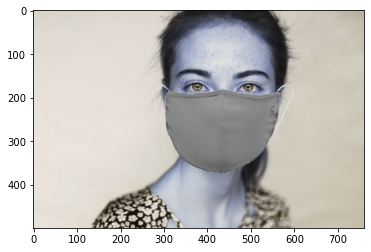

In [15]:
if target == 'i':
    frame = img
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)

    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # extract start and end points
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        rightEye = shape[rStart:rEnd]
        mouth = shape[mStart:mEnd]
        imouth = shape[imStart:imEnd]
        lbrow = shape[leStart:leEnd]
        nose = shape[nStart:nEnd]
        jaw = shape[jStart:jEnd]
        ulip = np.append(shape[48:55], shape[60:65][::-1], axis=0)
        blip = np.append(shape[54:60], [shape[48]], axis=0)
        blip = np.append(blip, [shape[60]], axis=0)
        blip = np.append(blip, shape[64:68][::-1], axis=0)

        # calc eyes ratio
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        ear = (leftEAR + rightEAR) / 2.0

        if ear < EYE_AR_THRESH:
            COUNTER += 1
        else:
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                TOTAL += 1
            COUNTER = 0

        # draw eyes
    #         leftEyeHull = cv2.convexHull(leftEye)
    #         rightEyeHull = cv2.convexHull(rightEye)
    #         cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
    #         cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)


        # if mouth is open, [draw mouth]
        if check_mouth_open(ulip, blip):
            imouthHull = cv2.convexHull(imouth)
            cv2.drawContours(frame, [imouthHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [imouthHull], -1, (0, 255, 0), 1)

            mouthHull = cv2.convexHull(mouth)
            cv2.drawContours(frame, [mouthHull], -1, (0, 255, 255), 1)
            cv2.drawContours(frame, [mouthHull], -1, (0, 255, 255), 1)

        # make eyes mask {
        face_mask_small = face_mask

        if not transparent[MASK_NAME]:
            gray_mask = cv2.cvtColor(face_mask_small, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(gray_mask, 230, 255, cv2.THRESH_BINARY_INV)
            face_mask2 = cv2.bitwise_and(face_mask_small, face_mask_small, mask=mask)
        else:
            gray_mask = cv2.cvtColor(face_mask_small, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(gray_mask, 30, 255, cv2.THRESH_BINARY)
            face_mask2 = cv2.bitwise_and(face_mask_small, face_mask_small, mask=mask)

        rows, cols = frame.shape[:2]

        dst_points = {'eyes': np.float32([shape[36], shape[45], shape[30]]),
                      'nose': np.float32([shape[30], shape[50], shape[52]]),
                      'brows': np.float32([shape[19], shape[27], shape[24]]),
                      'brows2': np.float32([shape[19], shape[27] -([0, shape[9][1] - shape[27][1]]), shape[24]]),
                      'moustache': np.float32([shape[49], shape[33], shape[53]]),
                      'left_ear': np.float32([shape[2], shape[1], shape[0]]),
                      'lips': np.float32([shape[8], shape[0], shape[16]])}
        M = cv2.getAffineTransform(src_points[MASK_NAME], dst_points[dst_points_names[MASK_NAME]])
        dst = cv2.warpAffine(face_mask2, M, (cols,rows))
        dst_mask = cv2.warpAffine(mask, M, (cols,rows))

        gray_dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        ret, mask_dst = cv2.threshold(dst_mask, 230, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask_dst)

        masked_frame = cv2.bitwise_and(frame, frame, mask=mask_inv)
        masked_dst = cv2.bitwise_and(dst, dst, mask=mask_dst)

        frame_new = cv2.add(masked_frame, masked_dst)
        # }

    plt.imshow(frame_new)
    cv2.imwrite(f"{result_dir}/{IMG_NAME[:-4]}_{MASK_NAME[:-4]}.jpg", frame_new)